# Neural Machine Translation

* You will build a Neural Machine Translation (NMT) model to translate human-readable dates ("25th of June, 2009") into machine-readable dates ("2009-06-25"). 
* You will do this using an attention model, one of the most sophisticated sequence-to-sequence models. 

## Librarys

In [1]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

import random
from utils.translation_utils.nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

## Translating Human Readable Dates Into Machine Readable Dates

The model we will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. So, we will we will perform a simpler "date translation" task to be able to experiment with these models without using massive datasets. The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). Basically, we will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

### Dataset

We will train the model on a dataset of 10,000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 71668.22it/s]


In [3]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('monday august 19 2024', '2024-08-19'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('22 may 1988', '1988-05-22'),
 ('8 jul 2008', '2008-07-08'),
 ('wednesday september 8 1999', '1999-09-08')]

we've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
    - **Note**: These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. 
- We will set Tx=30 
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set Ty=10
    - "YYYY-MM-DD" is 10 characters long.

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


Now we have:
- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`. 
    - Each date is padded to ensure a length of $T_x$ using a special character (< pad >). 
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index (integer) it is mapped to in `machine_vocab`. 
    - `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation (if the index is 2, the one-hot version has the index position 2 set to 1, and the remaining positions are 0.
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation. 
    - `Yoh.shape = (m, Ty, len(machine_vocab))`. 
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

In [5]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Neural Machine Translation with Attention

* If we had to translate a book's paragraph from French to English, we would not read the whole paragraph, then close the book and translate. 
* Even during the translation process, we would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English we are writing down. 
* The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

### Attention Mechanism

In this part, we will implement the attention mechanism presented in the lecture videos. 
* Here is a figure to remind we how the model works. 
    * The diagram on the left shows the attention model. 
    * The diagram on the right shows what one "attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$.
    * The attention variables $\alpha^{\langle t, t' \rangle}$ are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 
<center>
<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
</center>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>


Here are some properties of the model that we may notice: 

#### Pre-attention and Post-attention LSTMs on both sides of the attention mechanism
- There are two separate LSTMs in this model (see diagram on the left): pre-attention and post-attention LSTMs.
- *Pre-attention* Bi-LSTM is the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism.
    - The attention mechanism is shown in the middle of the left-hand diagram.
    - The pre-attention Bi-LSTM goes through $T_x$ time steps
- *Post-attention* LSTM: at the top of the diagram comes *after* the attention mechanism. 
    - The post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes the hidden state $s^{\langle t \rangle}$ and cell state $c^{\langle t \rangle}$ from one time step to the next. 

#### Each time step does not use predictions from the previous time step
* Unlike previous text generation examples, in this model, the post-attention LSTM at time $t$ does not take the previous time step's prediction $y^{\langle t-1 \rangle}$ as input.
* The post-attention LSTM at time 't' only takes the hidden state $s^{\langle t\rangle}$ and cell state $c^{\langle t\rangle}$ as input. 
* We have designed the model this way because unlike language generation (where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date.

#### Concatenation of hidden states from the forward and backward pre-attention LSTMs
- $\overrightarrow{a}^{\langle t \rangle}$: hidden state of the forward-direction, pre-attention LSTM.
- $\overleftarrow{a}^{\langle t \rangle}$: hidden state of the backward-direction, pre-attention LSTM.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: the concatenation of the activations of both the forward-direction $\overrightarrow{a}^{\langle t \rangle}$ and backward-directions $\overleftarrow{a}^{\langle t \rangle}$ of the pre-attention Bi-LSTM. 

#### Computing "energies" $e^{\langle t, t' \rangle}$ as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t' \rangle}$
- The definition of "e" as a function of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
    - "e" is called the "energies" variable.
    - $s^{\langle t-1 \rangle}$ is the hidden state of the post-attention LSTM
    - $a^{\langle t' \rangle}$ is the hidden state of the pre-attention LSTM.
    - $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ are fed into a simple neural network, which learns the function to output $e^{\langle t, t' \rangle}$.
    - $e^{\langle t, t' \rangle}$ is then used when computing the attention $\alpha^{\langle t, t' \rangle}$ that $y^{\langle t \rangle}$ should pay to $a^{\langle t' \rangle}$.

- The diagram on the right of figure 1 uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times.
- Then it uses `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$.
- The concatenation of $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ is fed into a "Dense" layer, which computes $e^{\langle t, t' \rangle}$. 
- $e^{\langle t, t' \rangle}$ is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$.
- Note that the diagram doesn't explicitly show variable $e^{\langle t, t' \rangle}$, but $e^{\langle t, t' \rangle}$ is above the Dense layer and below the Softmax layer in the diagram in the right half of figure 1.
- We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

#### Implementation Details
   
Let's implement this neural translator by implementing two functions: `one_step_attention()` and `model()`.

#### one_step_attention
* The inputs to the one_step_attention at time step $t$ are:
    - $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$: all hidden states of the pre-attention Bi-LSTM.
    - $s^{<t-1>}$: the previous hidden state of the post-attention LSTM 
* one_step_attention computes:
    - $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$: the attention weights
    - $context^{ \langle t \rangle }$: the context vector:
    
$$context^{<t>} = \sum_{t' = 1}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

- We are calling the context $context^{\langle t \rangle}$.
    - This is to avoid confusion with the post-attention LSTM's internal memory cell variable, which is also denoted $c^{\langle t \rangle}$.

* The function `model()` will call the layers in `one_step_attention()` $T_y$ times using a for-loop.
* It is important that all $T_y$ copies have the same weights. 
    * It should not reinitialize the weights every time. 
    * In other words, all $T_y$ steps should have shared weights. 

In [6]:
# Defined shared layers as global variables
def define_shared_layers():
    repeator = RepeatVector(Tx)
    concatenator = Concatenate(axis=-1)
    densor1 = Dense(10, activation = "tanh")
    densor2 = Dense(1, activation = "relu")
    activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
    dotor = Dot(axes = 1)

    return repeator, concatenator, densor1, densor2, activator, dotor

In [7]:
def one_step_attention(a, s_prev, layers):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """

    repeator, concatenator, densor1, densor2, activator, dotor = layers 
    
    s_prev = repeator(s_prev)
    concat = concatenator((a, s_prev))
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor((alphas, a))
    
    return context

### modelf

* `modelf` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `modelf` calls `one_step_attention()` $T_y$ times using a `for` loop. At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$.

1. Propagate the input `X` into a bi-directional LSTM.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) 
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Remember that we want the LSTM to return a full sequence instead of just the last hidden state.  
    
Sample code:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Iterate for $t = 0, \cdots, T_y-1$: 
    1. Call `one_step_attention()`, passing in the sequence of hidden states $[a^{\langle 1 \rangle},a^{\langle 2 \rangle}, ..., a^{ \langle T_x \rangle}]$ from the pre-attention bi-directional LSTM, and the previous hidden state $s^{<t-1>}$ from the post-attention LSTM to calculate the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. 
        - Remember to pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM 
        * This outputs the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.  
    3. Apply a dense, softmax layer to $s^{<t>}$, get the output.  
    4. Save the output by adding it to the list of outputs.

3. Create wer Keras model instance.
    * It should have three inputs:
        * `X`, the one-hot encoded inputs to the model, of shape ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, the initial hidden state of the post-attention LSTM
        * $c^{\langle 0 \rangle}$, the initial cell state of the post-attention LSTM
    * The output is the list of outputs.  

In [8]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    X = Input(shape=(Tx, human_vocab_size))  # Input for human-readable date
    s0 = Input(shape=(n_s,), name='s0')     # Initial hidden state for LSTM
    c0 = Input(shape=(n_s,), name='c0')     # Initial cell state for LSTM
    s = s0                                  # hidden state
    c = c0                                  # cell state
    
    outputs = []
    
    # Step 1: Define wer pre-attention Bi-LSTM.
    a = Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    layers = define_shared_layers()

    # Please note, this is the post attention LSTM cell.  
    post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
    output_layer = Dense(machine_vocab_size, activation=softmax)

    # Step 2: Iterate for Ty steps
    for t in range(Ty):

        # Attenuation        
        context = one_step_attention(a, s, layers)
        _, s, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Dense Layer
        out = output_layer(s)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs.
    model = Model(inputs=[X, s0, c0], outputs=outputs)
    
    return model

In [9]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

#### Troubleshooting Note
* If you are getting repeated errors after an initially incorrect implementation of "model", but believe that we have corrected the error, we may still see error messages when building wer model.  
* A solution is to save and restart wer kernel (or shutdown then restart wer notebook), and re-run the cells.

Let's get a summary of the model to check if it matches the expected output.

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[1][1],     │
│                     │                   │            │ lstm_1[2][1],     │
│                     │                   │            │ lstm_1[3][1],     │
│                     │                   │            │ lstm_1[4][1],     │
│                     │                   │            │ lstm_1[5][1],     │
│                     │                   │            │ lstm_1[6][1],     │
│                     │                   │            │ lstm_1[7][1],     │
│                     │                   │            │ lstm_1[8][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0… │
│                     │                   │            │ concatenate[8][0

 Total params: 52,960 (206.88 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

**Expected Output**:

Here is the summary we should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         52,960
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 64)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 64) 
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 128) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 64)
        </td>
    </tr>
           <tr>
        <td>
            **dense_3's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


### Compile the Model

* Loss function: 'categorical_crossentropy'.
* Optimizer: [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers)
    - learning rate = 0.005 
    - $\beta_1 = 0.9$
    - $\beta_2 = 0.999$
    - decay = 0.01  
* metric: 'accuracy'

In [11]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0, 1))

opt = Adam(learning_rate=0.005, beta_1 = 0.9, beta_2=0.999, decay=0.01)
metrics = ['accuracy'] * len(outputs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=metrics)

d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [12]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - dense_2_accuracy: 0.2591 - dense_2_accuracy_1: 0.5415 - dense_2_accuracy_2: 0.2140 - dense_2_accuracy_3: 0.0807 - dense_2_accuracy_4: 0.6859 - dense_2_accuracy_5: 0.3365 - dense_2_accuracy_6: 0.0520 - dense_2_accuracy_7: 0.7074 - dense_2_accuracy_8: 0.1985 - dense_2_accuracy_9: 0.0823 - loss: 19.3550


While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<center><img src="images/table.png" style="width:700;height:200px;"> <br></center>
<caption><center>Thus, <mark> dense_2_8_accuracy: 0.89 </mark> means that you are predicting the 9th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [13]:
model.load_weights('utils/translation_utils/model.h5')

You can now see the results on new examples.

In [14]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
source: 3 May 1979
output: 1979-05-33 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
source: 5 April 09
output: 2009-04-05 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
source: 21th of August 2016
output: 2016-08-20 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


You can also change these examples to test with your own examples. The next part will give you a better sense of what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 

<a name='3'></a>
## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (such as the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what each part of the output is looking at which part of the input.

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We also see that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 

<a name='3-1'></a>
### 3.1 - Getting the Attention Weights From the Network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 37)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ s0 (InputLayer)     │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 64)    │          0 │ s0[0][0],         │
│ (RepeatVector)      │                   │            │ lstm_1[0][1],     │
│                     │                   │            │ lstm_1[1][1],     │
│                     │                   │            │ lstm_1[2][1],     │
│                     │                   │            │ lstm_1[3][1],     │
│                     │                   │            │ lstm_1[4][1],     │
│                     │                   │            │ lstm_1[5][1],     │
│                     │                   │            │ lstm_1[6][1],     │
│                     │                   │            │ lstm_1[7][1],     │
│                     │                   │            │ lstm_1[8][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 30, 128)   │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[1]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[2]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[3]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[4]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[5]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[6]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[7]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[8]… │
│                     │                   │            │ bidirectional[0]… │
│                     │                   │            │ repeat_vector[9]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 10)    │      1,290 │ concatenate[0][0… │
│                     │                   │            │ concatenate[1][0… │
│                     │                   │            │ concatenate[2][0… │
│                     │                   │            │ concatenate[3][0… │
│                     │                   │            │ concatenate[4][0… │
│                     │                   │            │ concatenate[5][0… │
│                     │                   │            │ concatenate[6][0… │
│                     │                   │            │ concatenate[7][0… │
│                     │                   │            │ concatenate[8][0

 Total params: 158,882 (620.64 KB)

 Trainable params: 52,960 (206.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,922 (413.76 KB)

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Let's get the attention weights from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

**Note**: We are aware that you might run into an error running the cell below despite a valid implementation for Exercise 2 - `modelf` above. If  you have passed all implementations of the exercises above, don’t worry about the error, it will not affect the grading for this assignment.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Figure size 640x480 with 0 Axes>

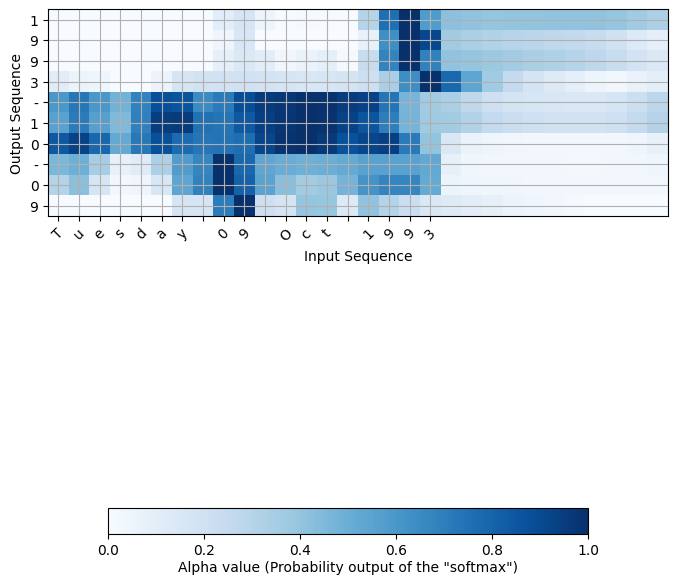

In [20]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that the places where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and doesn't have much impact on predicting the day or month.

**Conclusions:**
- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.